# CV - Project 1 Super-Resolution

## Imports

In [26]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import random
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError, Mean, binary_crossentropy, binary_accuracy
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, concatenate, Dropout, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError

### GPU Mounting

In [4]:
try:
    import google.colab
    in_colab = True
except ImportError:
    in_colab = False

if in_colab:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
    except ValueError:
        if 'GPU' in [gpu[-1] for gpu in tf.config.list_physical_devices('GPU')]:
            print('Running on Google Colab GPU')
        else:
            print('Not connected to a TPU or GPU runtime')

else:
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    try:
        if len(physical_devices):
            for gpu in physical_devices:
                tf.config.experimental.set_memory_growth(gpu, enable = True)
                print(f"Using local GPU: {gpu}")
            sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement = True))
        else:
            print("No local GPU found")
    except:
        print("Error Mounting a GPU")

[]
No local GPU found


## Data

### Functions

In [5]:
def filter_df(df, viable_nums=["2", "4", "6"]):
    condition = df['low_res'].str.endswith(tuple(num + ".jpg" for num in viable_nums))
    filtered_df = df[condition]
    return filtered_df

In [6]:
def read_images(df):
    new_df = pd.DataFrame(columns=["low_res", "high_res"])

    for index, row in df.iterrows():
            low_res_path = row["low_res"]
            low_res_img = Image.open(low_res_path)
            low_res_array = np.array(low_res_img)

            high_res_path = row["high_res"]
            high_res_img = Image.open(high_res_path)
            high_res_array = np.array(high_res_img)
            new_row = {
                "low_res" : low_res_array,
                "high_res" : high_res_array,
            }
            new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)
        
    return new_df

In [7]:
def show_random_image(df, num_rows=1, seed=42):
    random.seed(seed)
    plt.figure(figsize=(12, 3 * num_rows))

    for _ in range(num_rows):
        rand_idx = random.randint(0, len(df)-1)
        random_row = df.iloc[rand_idx]

        low_res_array = random_row["low_res"]
        high_res_array = random_row["high_res"]

        plt.subplot(num_rows, 2, 2 * _ + 1)
        plt.imshow(low_res_array)
        plt.title(f"Low Resolution - Row {rand_idx}")
        plt.axis("off")

        plt.subplot(num_rows, 2, 2 * _ + 2)
        plt.imshow(high_res_array)
        plt.title(f"High Resolution - Row {rand_idx}")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

In [8]:
def reshape_images(df, target_shape = (800, 1200)):
    new_df = pd.DataFrame(columns=["low_res", "high_res"])

    for index, row in df.iterrows():
        low_res_img = cv2.resize(row["low_res"], target_shape[::-1]) /255.0
        high_res_img = cv2.resize(row["high_res"], target_shape[::-1]) /255.0
        new_row = {
            "low_res": low_res_img,
            "high_res": high_res_img
        }
        new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)

    return new_df

### Data Reading

In [9]:
base_directory = 'Data'
hires_folder = os.path.join(base_directory, 'high res')
lowres_folder = os.path.join(base_directory, 'low res')

In [10]:
data = pd.read_csv("Data/image_data.csv")
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder,x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder,x))
data.head()

low_res             high_res
0  Data\low res\1_2.jpg  Data\high res\1.jpg
1  Data\low res\2_2.jpg  Data\high res\2.jpg
2  Data\low res\3_2.jpg  Data\high res\3.jpg
3  Data\low res\4_2.jpg  Data\high res\4.jpg
4  Data\low res\5_2.jpg  Data\high res\5.jpg

In [11]:
new_data = filter_df(data, viable_nums=["6"])
new_data.head()

low_res             high_res
2508  Data\low res\1_6.jpg  Data\high res\1.jpg
2509  Data\low res\2_6.jpg  Data\high res\2.jpg
2510  Data\low res\3_6.jpg  Data\high res\3.jpg
2511  Data\low res\4_6.jpg  Data\high res\4.jpg
2512  Data\low res\5_6.jpg  Data\high res\5.jpg

In [12]:
images_df = read_images(new_data)
images_df.head()

low_res  \
0  [[[21, 41, 6], [21, 41, 6], [21, 40, 8], [23, ...   
1  [[[226, 226, 228], [226, 226, 228], [226, 226,...   
2  [[[26, 14, 16], [26, 14, 16], [26, 14, 16], [2...   
3  [[[3, 1, 15], [3, 1, 15], [3, 1, 15], [3, 1, 1...   
4  [[[205, 187, 163], [205, 187, 163], [205, 187,...   

                                            high_res  
0  [[[21, 41, 6], [22, 42, 7], [24, 44, 7], [24, ...  
1  [[[226, 226, 228], [226, 226, 228], [226, 226,...  
2  [[[23, 11, 13], [25, 13, 15], [27, 15, 17], [2...  
3  [[[3, 1, 15], [3, 1, 15], [3, 1, 15], [3, 1, 1...  
4  [[[204, 186, 162], [204, 186, 162], [204, 186,...

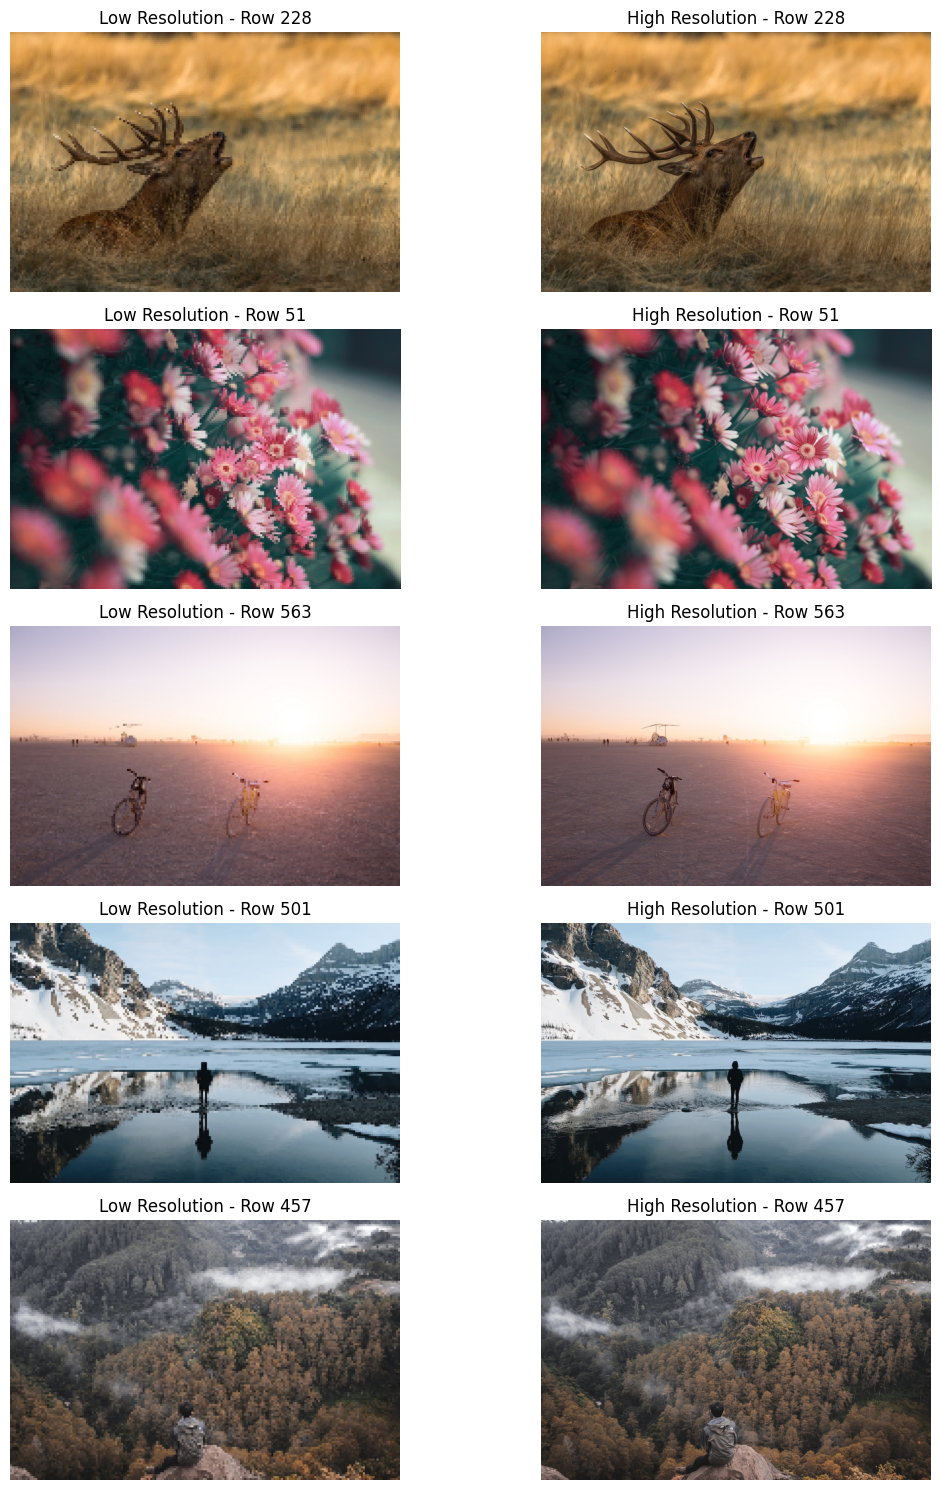

In [13]:
show_random_image(images_df, num_rows=5)

By default most images seem to have a shape (800, 1200, 3) for both low_res and high_res, however some exceptions are present so we should rescale all images to be the same shape

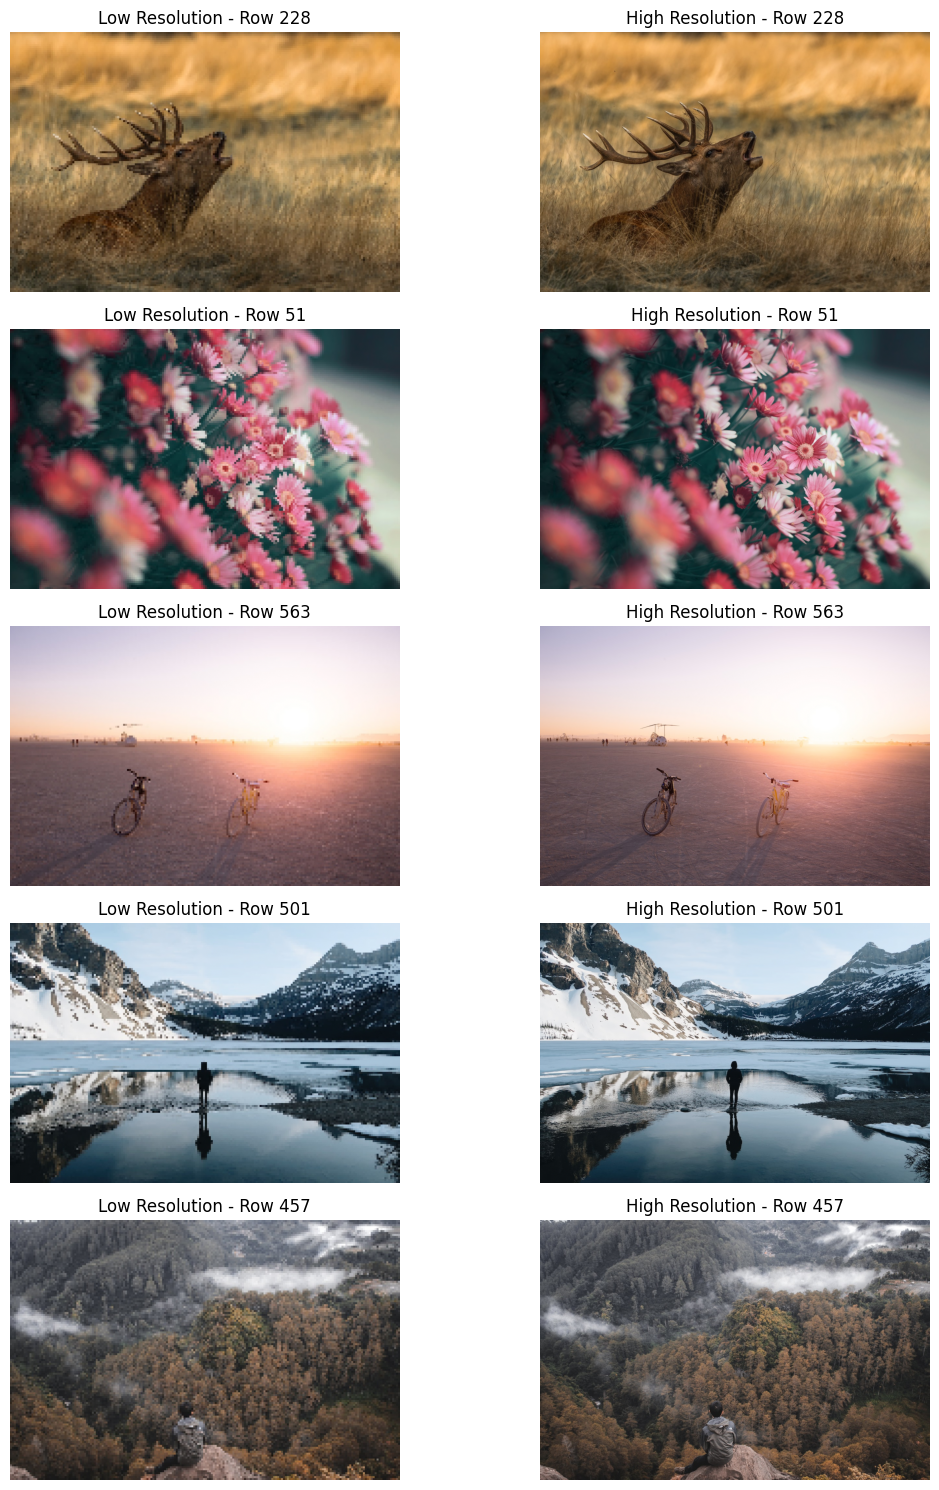

In [14]:
reshaped_df = reshape_images(images_df, target_shape = (800, 1200))
show_random_image(reshaped_df, num_rows=5)

## Models

### Standard Convolutional

In [22]:
def build_conv_model(input_shape=(800, 1200, 3)):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(16, (3, 3), padding='same', activation='elu')(input_img)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv1)
    conv3 = Conv2D(64, (3, 3), padding='same', activation='elu')(conv2)
    conv4 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv3)
    conv5 = Conv2D(16, (3, 3), padding='same', activation='elu')(conv4)

    # Output layer
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv5)

    conv_model = Model(input_img, output_img)
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    conv_model.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)

    return conv_model

In [23]:
conv_model = build_conv_model()
conv_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 800, 1200, 3)]    0         
                                                                 
 conv2d_21 (Conv2D)          (None, 800, 1200, 16)     448       
                                                                 
 conv2d_22 (Conv2D)          (None, 800, 1200, 32)     4640      
                                                                 
 conv2d_23 (Conv2D)          (None, 800, 1200, 64)     18496     
                                                                 
 conv2d_24 (Conv2D)          (None, 800, 1200, 32)     18464     
                                                                 
 conv2d_25 (Conv2D)          (None, 800, 1200, 16)     4624      
                                                                 
 conv2d_26 (Conv2D)          (None, 800, 1200, 3)      435 

### Autoencoders

In [24]:
def build_autoencoder_model(input_shape=(800, 1200, 3)):
    # Input layer
    input_img = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same', activation='elu')(input_img)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv1)
    maxpool1 = MaxPooling2D(padding='same')(conv2)
    dropout1 = Dropout(0.2)(maxpool1)
    maxpool2 = MaxPooling2D(padding='same')(dropout1)
    conv3 = Conv2D(64, (3, 3), padding='same', activation='elu')(maxpool2)

    # Decoder
    upsample1 = UpSampling2D()(conv3)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='elu')(upsample1)
    conv5 = Conv2D(64, (3, 3), padding='same', activation='elu')(conv4)

    upsample2 = UpSampling2D()(conv5)
    conv6 = Conv2D(32, (3, 3), padding='same', activation='elu')(upsample2)
    conv7 = Conv2D(16, (3, 3), padding='same', activation='elu')(conv6)

    # Output layer
    decoded = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv7)

    # Create and compile Autoencoder model
    autoencoder = Model(input_img, decoded)
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)

    return autoencoder

In [25]:
autoencoder = build_autoencoder_model()
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 800, 1200, 3)]    0         
                                                                 
 conv2d_27 (Conv2D)          (None, 800, 1200, 16)     448       
                                                                 
 conv2d_28 (Conv2D)          (None, 800, 1200, 32)     4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 400, 600, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 400, 600, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 200, 300, 32)      0         
 g2D)                                                      

### U-Net like architecture

In [49]:
def build_u_net(input_shape=(800, 1200, 3)):
    # Input layer
    input_img = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    conv2 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv1)
    maxpool1 = MaxPooling2D()(conv2)

    conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
    conv4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv3)
    maxpool2 = MaxPooling2D()(conv4)

    conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool2)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv5)

    # Bottleneck
    bottleneck = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
    maxpool3 = MaxPooling2D(pool_size=(2, 2))(bottleneck)

    # Decoder
    upsample1 = UpSampling2D()(maxpool3)
    concat1 = concatenate([upsample1, conv5], axis=-1)
    conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')(concat1)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv7)

    upsample2 = UpSampling2D()(conv8)
    concat2 = concatenate([upsample2, conv3], axis=-1)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
    conv10 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv9)

    upsample3 = UpSampling2D()(conv10)
    concat3 = concatenate([upsample3, conv1], axis=-1)
    conv11 = Conv2D(16, (3, 3), padding='same', activation='relu')(concat3)
    conv12 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv11)

    # Output layer
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv12)

    unet = Model(input_img, output_img)    
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    unet.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)
    
    return unet

In [50]:
Unet = build_u_net()
Unet.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 800, 1200, 3)]       0         []                            
                                                                                                  
 conv2d_154 (Conv2D)         (None, 800, 1200, 16)        448       ['input_18[0][0]']            
                                                                                                  
 conv2d_155 (Conv2D)         (None, 800, 1200, 16)        2320      ['conv2d_154[0][0]']          
                                                                                                  
 max_pooling2d_34 (MaxPooli  (None, 400, 600, 16)         0         ['conv2d_155[0][0]']          
 ng2D)                                                                                      

### Inception like model version 1

In [51]:
def inception_block(x, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[2], (5, 5), padding='same', activation='relu')(x)
    pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    inception_block = concatenate([conv1x1, conv3x3, conv5x5, pool], axis=-1)

    return inception_block

In [55]:
def build_inception_model(input_shape=(800, 1200, 3)):
    input_img = Input(shape=input_shape)
    inception1 = inception_block(input_img, [8, 8, 8])
    incpetion2 = inception_block(inception1, [16, 16, 16])
    partial_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(incpetion2)
    inception3 = inception_block(incpetion2, [32, 32, 32])
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(inception3)
    
    inception = Model(inputs=input_img, outputs=[output_img, partial_img])    
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    inception.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)
    
    return inception

In [56]:
inception = build_inception_model()
inception.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 800, 1200, 3)]       0         []                            
                                                                                                  
 conv2d_192 (Conv2D)         (None, 800, 1200, 8)         32        ['input_21[0][0]']            
                                                                                                  
 conv2d_193 (Conv2D)         (None, 800, 1200, 8)         224       ['input_21[0][0]']            
                                                                                                  
 conv2d_194 (Conv2D)         (None, 800, 1200, 8)         608       ['input_21[0][0]']            
                                                                                           

### Inception like model version 2

In [2]:
def alt_inception_block(x, filters):
    conv1x1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    conv1x1_2 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    conv1x1_3 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1x1_2)
    conv5x5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(conv1x1_3)
    pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_4 = Conv2D(filters, (1, 1), padding='same', activation='relu')(pool)
    inception_block = concatenate([conv1x1, conv3x3, conv5x5, conv1x1_4], axis=-1)

    return inception_block

In [11]:
def build_alt_inception_model(input_shape=(800, 1200, 3)):
    input_img = Input(shape=input_shape)
    
    conv1 = Conv2D(4, (7, 7), padding='same', activation='relu')(input_img)
    maxpool1 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(conv1)
    batch1 = BatchNormalization()(maxpool1)
    
    conv2 = Conv2D(8, (1, 1), padding='same', activation='relu')(batch1)
    conv3 = Conv2D(8, (1, 1), padding='same', activation='relu')(conv2)
    batch2 = BatchNormalization()(conv3)
    maxpool2 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(batch2)

    inception1 = alt_inception_block(maxpool2, 8)
    output_img_1 = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(inception1)
    batch3 = BatchNormalization()(inception1)
    incpetion2 = alt_inception_block(batch3, 16)
    output_img_2 = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(incpetion2)
    batch4 = BatchNormalization()(incpetion2)
    inception3 = alt_inception_block(batch4, 32)
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(inception3)
    
    inception = Model(inputs=input_img, outputs=[output_img, output_img_1, output_img_2])    
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    inception.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)
    
    return inception

In [12]:
inception_alt = build_alt_inception_model()
inception_alt.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 800, 1200, 3)]       0         []                            
                                                                                                  
 conv2d_87 (Conv2D)          (None, 800, 1200, 4)         592       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_17 (MaxPooli  (None, 800, 1200, 4)         0         ['conv2d_87[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 batch_normalization_16 (Ba  (None, 800, 1200, 4)         16        ['max_pooling2d_17[0][0]

### Skip-Connections model

In [72]:
def build_skip_connections_model(input_shape=(800, 1200, 3)):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv2)
    conv4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv3)
    concat1 = add([conv3, conv4])
    conv5 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    concat2 = add([concat1, conv5])
    conv6 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
    concat3 = add([concat2, conv6])
    concat4 = add([concat3, conv2])
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat4)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv7)
    conv9 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv8)

    # Output layer
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv9)

    skip_model = Model(input_img, output_img)
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    skip_model.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)

    return skip_model

In [73]:
skip_model = build_skip_connections_model()
skip_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 800, 1200, 3)]       0         []                            
                                                                                                  
 conv2d_253 (Conv2D)         (None, 800, 1200, 16)        448       ['input_27[0][0]']            
                                                                                                  
 conv2d_254 (Conv2D)         (None, 800, 1200, 32)        4640      ['conv2d_253[0][0]']          
                                                                                                  
 conv2d_255 (Conv2D)         (None, 800, 1200, 32)        9248      ['conv2d_254[0][0]']          
                                                                                           

### Skip-Connections model version 2

In [31]:
def build_skip_connections_model_2(input_shape=(800, 1200, 3)):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(8, (3, 3), padding='same', activation='relu')(input_img)
    conv1 = Dropout(0.2)(conv1)
    conv2 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv1)
    conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv2)
    conv3 = BatchNormalization()(conv3)
    concat1 = concatenate([conv1, conv3], axis=-1)

    conv4 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat1)
    conv5 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv4)
    conv5 = BatchNormalization()(conv5)
    concat2 = concatenate([conv2, conv5], axis=-1)
    concat3 = concatenate([concat1, concat2], axis=-1)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(concat3)
    conv6 = Dropout(0.2)(conv6)
    hidden_conv = Conv2D(8, (7, 7), padding='same', activation='elu')(conv1)
    hidden_conv = AveragePooling2D((5, 5), strides=(1, 1), padding='same')(hidden_conv) 
    concat4 = concatenate([conv6, hidden_conv], axis=-1)
    conv7 = Conv2D(64, (3, 3), padding='same', activation='elu')(concat4)

    # Output layer
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv7)

    skip_model = Model(input_img, output_img)
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    skip_model.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)

    return skip_model

In [32]:
skip_model_2 = build_skip_connections_model_2()
skip_model_2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 800, 1200, 3)]       0         []                            
                                                                                                  
 conv2d_181 (Conv2D)         (None, 800, 1200, 8)         224       ['input_15[0][0]']            
                                                                                                  
 dropout_4 (Dropout)         (None, 800, 1200, 8)         0         ['conv2d_181[0][0]']          
                                                                                                  
 conv2d_182 (Conv2D)         (None, 800, 1200, 16)        1168      ['dropout_4[0][0]']           
                                                                                           

### GANs

In [35]:
def make_generator_model(input_shape=(800, 1200, 3)):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(8, (3, 3), padding='same', activation='elu')(input_img)
    conv2 = Conv2D(16, (3, 3), padding='same', activation='elu')(conv1)
    conv3 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv2)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='elu')(conv3)
    concat1 = concatenate([conv2, conv4], axis=-1)
    conv5 = Conv2D(64, (3, 3), padding='same', activation='elu')(concat1)
    output_img = Conv2D(64, (3, 3), padding='same', activation='sigmoid')(conv5)

    # Create the model
    generator_model = Model(inputs=input_img, outputs=output_img)
    return generator_model

In [36]:
generator_model = make_generator_model()
generator_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 800, 1200, 3)]       0         []                            
                                                                                                  
 conv2d_195 (Conv2D)         (None, 800, 1200, 8)         224       ['input_17[0][0]']            
                                                                                                  
 conv2d_196 (Conv2D)         (None, 800, 1200, 16)        1168      ['conv2d_195[0][0]']          
                                                                                                  
 conv2d_197 (Conv2D)         (None, 800, 1200, 32)        4640      ['conv2d_196[0][0]']          
                                                                                           

In [54]:
def make_discriminator_model(input_shape=(800, 1200, 3)):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(8, (7, 7), activation='relu')(input_img)
    conv2 = Conv2D(16, (7, 7), activation='relu')(conv1)
    conv3 = Conv2D(32, (7, 7), activation='relu')(conv2)
    conv4 = Conv2D(4, (7, 7), activation='relu')(conv3)
    maxpool1 = MaxPooling2D((7, 7))(conv4)
    flatten = Flatten()(maxpool1)
    output_img = Dense(1, activation='sigmoid')(flatten)

    # Create the model
    discriminator_model = Model(inputs=input_img, outputs=output_img)
    return discriminator_model

In [55]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 800, 1200, 3)]    0         
                                                                 
 conv2d_230 (Conv2D)         (None, 794, 1194, 8)      1184      
                                                                 
 conv2d_231 (Conv2D)         (None, 788, 1188, 16)     6288      
                                                                 
 conv2d_232 (Conv2D)         (None, 782, 1182, 32)     25120     
                                                                 
 conv2d_233 (Conv2D)         (None, 776, 1176, 4)      6276      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 110, 168, 4)       0         
 ng2D)                                                           
                                                          

In [56]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [57]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [58]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [59]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

## Training

In [ ]:
#X=reshaped_df["low_res"].values
#y=reshaped_df["high_res"].values
#X = np.stack(X, axis=0)
#y = np.stack(y, axis=0)
#autoencoder.fit(X,y,epochs=10,validation_split=0.1)

## Results